In [1]:
import json

import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from tqdm import tqdm

import tools.utils as utils
import tools.points_processing as pp

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, LSTM, GRU, Conv1D, Flatten, MaxPool1D, Dropout
from keras.metrics import binary_accuracy, binary_crossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.utils import class_weight

from xgboost import XGBClassifier

from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [23]:
def write_report(classifier, train_data, train_labels, test_data, test_labels, keras=False):
    """
    Evaluates the classifier.
    """
    train_preds = classifier.predict(train_data)
    test_preds = classifier.predict(test_data)
    
    if keras:
        train_preds = train_preds > .5
        test_preds = test_preds > .5
    
    print("Training data (less important):")
    print(" Accuracy: %.5f\n Precision: %.5f\n Recall: %.5f\n \033[91m F1 score (class 1): %.5f\n\033[0m F1 score (class 0): %.5f" 
          % (accuracy_score(train_labels, train_preds),
             precision_score(train_labels, train_preds),
             recall_score(train_labels, train_preds),
             f1_score(train_labels, train_preds),
             f1_score(train_labels, train_preds, pos_label=0)
            ))
    
    print("Test data (more important):")
    print(" Accuracy: %.5f\n Precision: %.5f\n Recall: %.5f\n \033[91m F1 score (class 1): %.5f\n\033[0m F1 score (class 0): %.5f" 
          % (accuracy_score(test_labels, test_preds),
             precision_score(test_labels, test_preds),
             recall_score(test_labels, test_preds),
             f1_score(test_labels, test_preds),
             f1_score(test_labels, test_preds, pos_label=0)
            ))

In [2]:
df = pp.prepare_points()

In [3]:
time, low_labels, up_labels, lowT, upT = pp.prepare_data()

In [4]:
pos_time_data, pos_temp_data = pp.generate_positive(low_labels, time, lowT)
print(pos_temp_data.shape)

100%|██████████| 791858/791858 [00:04<00:00, 165430.28it/s]

(2930, 20)


In [5]:
start = 80000
end   = 750000
neg_time_data, neg_temp_data = pp.generate_negative(low_labels[start:end], time[start:end], lowT[start:end])

print(neg_temp_data.shape)

100%|██████████| 670000/670000 [00:04<00:00, 163906.04it/s]

(12979, 20)


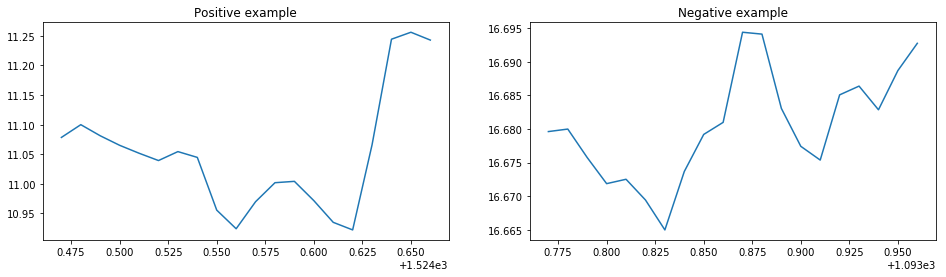

In [6]:
plt.rcParams['figure.figsize'] = [16, 4]

idx = 491

plt.subplot(121)
plt.plot(pos_time_data[idx]/1000., pos_temp_data[idx])
plt.title("Positive example")

idx = 485

plt.subplot(122)
plt.plot(neg_time_data[idx]/1000., neg_temp_data[idx])
plt.title("Negative example")
plt.show()

In [7]:
pos_labels = np.ones(pos_temp_data.shape[0])
neg_labels = np.zeros(neg_temp_data.shape[0])

In [8]:
print(pos_labels.shape)
print(neg_labels.shape)

(2930,)
(12979,)


In [26]:
X_data = np.concatenate((pos_temp_data, neg_temp_data))
Y_data = np.concatenate((pos_labels, neg_labels))

In [20]:
# mu = X_data.mean(1, keepdims=True)
# sigma = X_data.std(1, keepdims=True)
# X_data_norm = (X_data - mu) / sigma

X_data_norm = X_data - X_data[:,0:1]

In [21]:
X_data.shape

(15909, 20)

In [12]:
X_data_norm = np.expand_dims(X_data_norm, 2)

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data_norm, Y_data, test_size=.1, random_state=0)

print(X_train.shape)
print(X_test.shape)

(14318, 20)
(1591, 20)


In [90]:
inputs = Input(shape=(20,1))
X = Conv1D(20, 3, activation='relu')(inputs)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Conv1D(40, 3, activation='relu')(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Conv1D(40, 3, activation='relu')(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Conv1D(50, 3, activation='relu')(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Conv1D(50, 3, activation='relu')(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Flatten()(X)
X = Dense(1,  activation='sigmoid')(X)

model = Model(inputs=[inputs], outputs=[X])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 20, 1)             0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 18, 20)            80        
_________________________________________________________________
dropout_42 (Dropout)         (None, 18, 20)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16, 40)            2440      
_________________________________________________________________
dropout_43 (Dropout)         (None, 16, 40)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 14, 40)            4840      
_________________________________________________________________
dropout_44 (Dropout)         (None, 14, 40)            0         
__________

In [40]:
inputs = Input(shape=(20,1))
X = LSTM(20, return_sequences=True)(inputs)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = LSTM(50, return_sequences=True)(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = LSTM(30, return_sequences=False)(X)
#X = MaxPool1D(2)(X)
X = Dropout(.5)(X)

X = Dense(1,  activation='sigmoid')(X)

model = Model(inputs=[inputs], outputs=[X])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20, 1)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 20)            1760      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 20)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 50)            14200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                9720      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
__________

In [41]:
model.compile('adam', 'binary_crossentropy', metrics=['binary_accuracy'])

In [42]:
weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)

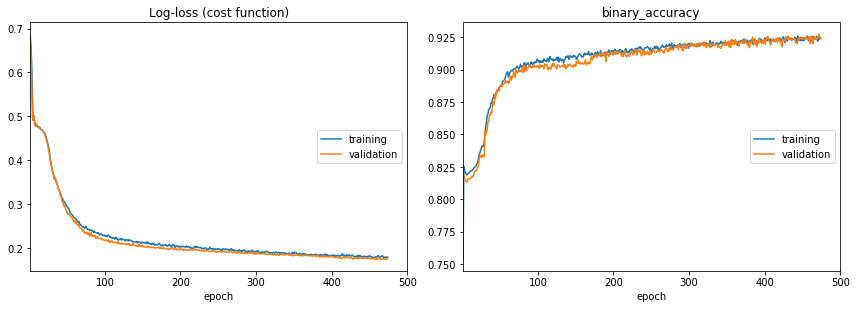

In [ ]:
model.fit(X_train, Y_train, 
          epochs=500, 
          batch_size=4000, 
          class_weight=weight, 
          validation_data=(X_test, Y_test), 
          verbose=0,
          callbacks=[PlotLossesKeras()])

- Rethink sync (!)

- Add more features (wind, other thermometers etc.)

- Conv models

In [35]:
print(model.evaluate(X_train, Y_train, batch_size=4000))
print(model.evaluate(X_test, Y_test, batch_size=4000))

14313/14313 [==============================] - 0s 13us/step
[0.16962278874541931, 0.92447426739224081]
1591/1591 [==============================] - 0s 18us/step
[0.17060592770576477, 0.92834693193435669]


In [37]:
write_report(model, X_train, Y_train, X_test, Y_test, keras=True)

Training data (less important):
 Accuracy: 0.92447
 Precision: 0.81265
 Recall: 0.76605
  F1 score (class 1): 0.78866
 F1 score (class 0): 0.95402
Test data (more important):
 Accuracy: 0.92835
 Precision: 0.82979
 Recall: 0.78000
  F1 score (class 1): 0.80412
 F1 score (class 0): 0.95615
